# Behavioral results

### Imports

In [1]:
import os
import re
import glob
import os
import ast
import os.path as op
from collections import defaultdict
from copy import deepcopy
import copy

import pickle
from time import time
import pywt
import mne
import scipy
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import pandas as pd
import cesium.featurize
from plotly.subplots import make_subplots
from ipywidgets import Dropdown, FloatRangeSlider, IntSlider, FloatSlider, interact
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import Pipeline
import scipy

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import permutation_test_score
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from tempfile import mkdtemp
from sklearn.linear_model import Ridge
from sklearn.kernel_ridge import KernelRidge
from mne.decoding import SPoC


from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
from scipy.stats import ttest_ind
from scipy.stats import ttest_rel

# import pingouin as pg

from sklearn.decomposition import FastICA
from sklearn.decomposition import PCA

from transformers import *

import warnings

warnings.filterwarnings("ignore")

import sys

---
## Load data

Loading EEG data and data from rumination questionnaire. By default create_df_data loads all info from given file but one can specify it by passing a list of desired labels from csv file.

In [2]:
# paths TODO
dir_path = os.path.dirname(os.path.abspath(""))

In [3]:
# tmin, tmax = -0.101562, 0.5937525  # Start and end of the segments
tmin, tmax = -0.1, 0.6  # Start and end of the segments

signal_frequency = 256
random_state = 0

In [4]:
def create_df_data(
    test_participants=False,
    test_epochs=False,
    info_filename=None,
    info="all",
    personal=True,
):
    """Loads data for all participants and create DataFrame with optional additional info from given .csv file.

    On default, loads a train set: chooses only 80% of participants
    and for each of them chooses 80% of epochs.
    It will choose them deterministically.

    Participants with less than 10 epochs per condition are rejected.

    If test_participants is set to True, it will load remaining 20% of participants.
    If test_epochs is set to True, it will load remaining 20% of epochs.
    Test epochs are chronologically after train epochs,
    because it reflects real usage (first callibration and then classification).

    Parameters
    ----------
    test_participants: bool
        whether load data for training or final testing.
        If true load participants data for testing.
    test_epochs: bool
        whether load data for training or final testing.
        If true load epochs of each participants data for testing.
    info_filename: String | None
        path to .csv file with additional data.
    info: array
        listed parameters from the info file to be loaded.
        if 'all', load all parameters
    personal: bool
        whether a model will be both trained and tested on epochs from one person
        if false, person's epochs aren't split into test and train


    Returns
    -------
    go_nogo_data_df : pandas.DataFrame

    """
    print(os.path.abspath(""))
    dir_path = os.path.dirname(os.path.abspath(""))
    print(dir_path)
    header_files_glob = os.path.join(dir_path, "data/responses_100_600/*.vhdr")
    header_files = glob.glob(header_files_glob)

    header_files = sorted(header_files)
    go_nogo_data_df = pd.DataFrame()

    # cut 20% of data for testing
    h_train, h_test = train_test_split(header_files, test_size=0.3, random_state=0)
    
    print(f"train size: {len(h_train)} ; test size: {len(h_test)}")

    if test_participants:
        header_files = h_test
    else:
        header_files = h_train

    for file in header_files:
        #  load eeg data for given participant
        participant_epochs = load_epochs_from_file(file)

        # and compute participant's id from file_name
        participant_id = re.match(r".*_(\w+).*", file).group(1)

        error = participant_epochs["error_response"]._data
        correct = participant_epochs["correct_response"]._data

        # exclude those participants who have too few samples
        if len(error) < 5 or len(correct) < 5:
            # not enough data for this participant
            continue

        # construct dataframe for participant with: id|epoch_data|response_type|additional info...
        participant_df = create_df_from_epochs(
            participant_id, participant_epochs, info_filename, info
        )
        print(participant_id)
        go_nogo_data_df = go_nogo_data_df.append(participant_df, ignore_index=True)

    return go_nogo_data_df

In [5]:
def create_df_from_epochs(id, participant_epochs, info_filename, info):
    """Create df for each participant. DF structure is like: {id: String ; epoch: epoch_data ; marker: 1.0|0.0}
    1.0 means correct and 0.0 means error response.
    Default info extracted form .csv file is 'Rumination Full Scale' and participants' ids.
    With this info df structure is like:
    {id: String ; epoch: epoch_data ; marker: 1.0|0.0 ; File: id ; 'Rumination Full Scale': int}

    Parameters
    ----------
    id: String
        participant's id extracted from filename
    correct: array
        correct responses' data
    error: array
        error responses' data
    info_filename: String
        path to .csv file with additional data.
    info: array
        listed parameters from the info file to be loaded.
        if 'all', load all parameters

    Returns
    -------
    participant_df : pandas.DataFrame

    """
    participant_df = pd.DataFrame()
    info_df = pd.DataFrame()

    # get additional info from file
    if info_filename is not None:
        if info == "all":
            rumination_df = pd.read_csv(info_filename)
        else:
            rumination_df = pd.read_csv(info_filename, usecols=["Demo_kod"] + info)
        info_df = (
            rumination_df.loc[rumination_df["Demo_kod"] == id]
            .reset_index()
            .drop("index", axis=1)
        )
        
    epoch_df = pd.DataFrame({"id": [id], "epoch": [participant_epochs], "marker": [ALL]}).join(
            info_df
        )
    participant_df = participant_df.append(epoch_df, ignore_index=True)

    return participant_df

In [6]:
def load_epochs_from_file(file, reject_bad_segments="auto", mask=None):
    """Load epochs from a header file.

    Args:
        file: path to a header file (.vhdr)
        reject_bad_segments: 'auto' means that bad segments are rejected automatically.

    Returns:
        mne Epochs

    """
    # Import the BrainVision data into an MNE Raw object
    raw = mne.io.read_raw_brainvision(file)

    # Construct annotation filename
    annot_file = file[:-4] + "vmrk"

    # Read in the event information as MNE annotations
    annotations = mne.read_annotations(annot_file)

    # Add the annotations to our raw object so we can use them with the data
    raw.set_annotations(annotations)

    # Map with response markers only
    event_dict = {
        "Stimulus/RE*ex*1_n*1_c_1*R*FB": 10004,
        "Stimulus/RE*ex*1_n*1_c_1*R*FG": 10005,
        "Stimulus/RE*ex*1_n*1_c_2*R": 10006,
        "Stimulus/RE*ex*1_n*2_c_1*R": 10007,
        "Stimulus/RE*ex*2_n*1_c_1*R": 10008,
        "Stimulus/RE*ex*2_n*2_c_1*R*FB": 10009,
        "Stimulus/RE*ex*2_n*2_c_1*R*FG": 10010,
        "Stimulus/RE*ex*2_n*2_c_2*R": 10011,
    }

    # Map for merged correct/error response markers
    merged_event_dict = {"correct_response": 0, "error_response": 1}

    # Reconstruct the original events from Raw object
    events, event_ids = mne.events_from_annotations(raw, event_id=event_dict)

    # Merge correct/error response events
    merged_events = mne.merge_events(
        events,
        [10004, 10005, 10009, 10010],
        merged_event_dict["correct_response"],
        replace_events=True,
    )
    merged_events = mne.merge_events(
        merged_events,
        [10006, 10007, 10008, 10011],
        merged_event_dict["error_response"],
        replace_events=True,
    )

    epochs = []
    this_reject_by_annotation = True

    # Read epochs
    epochs = mne.Epochs(
        raw=raw,
        events=merged_events,
        event_id=merged_event_dict,
        tmin=tmin,
        tmax=tmax,
        baseline=None,
        reject_by_annotation=this_reject_by_annotation,
        preload=True,
    )
    
    return epochs

#### Read the training data

In [7]:
df_name = "go_nogo_100_600_df_3-5_all_scales"
pickled_data_filename = "../data/responses_100_600_pickled/" + df_name + ".pkl"
# info_filename = "../data/Demographic_Questionnaires_Behavioral_Results_N=163.csv"
info_filename = "../data/scales/all_scales.csv"


# Check if data is already loaded
if os.path.isfile(pickled_data_filename):
    print("Pickled file found. Loading pickled data...")
    epochs_df = pd.read_pickle(pickled_data_filename)
    print("Done")
    pass
else:
    print("Pickled file not found. Loading data...")
    epochs_df = create_df_data(
        test_participants=False, info="all", personal=False, info_filename=info_filename
    )
    epochs_df.name = df_name
    # save loaded data into a pickle file
    epochs_df.to_pickle("../data/" + epochs_df.name + ".pkl")
    print("Done. Pickle file created")

Pickled file found. Loading pickled data...
Done


#### Read the external testing data

In [8]:
df_name = "go_nogo_100_600_test_df_3-5_all_scales"
pickled_data_filename = "../data/responses_100_600_pickled/" + df_name + ".pkl"
# info_filename = "../data/Demographic_Questionnaires_Behavioral_Results_N=163.csv"
info_filename = "../data/scales/all_scales.csv"


# Check if data is already loaded
if os.path.isfile(pickled_data_filename):
    print("Pickled file found. Loading pickled data...")
    epochs_test_df = pd.read_pickle(pickled_data_filename)
    print("Done")
else:
    print("Pickled file not found. Loading data...")
    epochs_test_df = create_df_data(
        test_participants=True, info="all", personal=False, info_filename=info_filename
    )
    epochs_test_df.name = df_name
    # save loaded data into a pickle file
    epochs_test_df.to_pickle("../data/" + epochs_test_df.name + ".pkl")
    print("Done. Pickle file created")

Pickled file found. Loading pickled data...
Done


Fill Nans

In [9]:
X_train_df = epochs_df
X_test_df = epochs_test_df

In [10]:
X_train_df = X_train_df.fillna(X_train_df.mean())
X_test_df = X_test_df.fillna(X_test_df.mean())

#### Read questionnaire and behavioral data

In [ ]:
stats_df = pd.read_csv("../data/scales/all_scales_with_rt_edited.csv")

#### Read demographic data

In [33]:
demgraphic_df = pd.read_csv("../data/scales/demographic_data.csv")

## Calculate response time (RT) stats

In [16]:
ID_train_list = X_train_df.id.to_list()
ID_test_list = X_test_df.id.to_list()

In [17]:
train_df = stats_df[stats_df['Demo_kod'].isin(ID_train_list)]
test_df = stats_df[stats_df['Demo_kod'].isin(ID_test_list)]

### The train dataset stats

Extract RT of correct and error trials

In [18]:
error_rt = train_df["mean_error_RT"].to_numpy()
correct_rt = train_df["mean_hit_RT"].to_numpy()
error_trials_num = train_df["number_error"].to_numpy()
correct_trials_num = train_df["number_fast_hit"].to_numpy() + train_df["number_slow_hit"].to_numpy()

Stats of responses

In [19]:
print(f"X train average number of:\n erroneous responses: {error_trials_num.mean()} SD = {error_trials_num.std()}\n correct responses: {correct_trials_num.mean()} SD = {correct_trials_num.std()}")

X train average number of:
 erroneous responses: 29.75 SD = 16.194134740701646
 correct responses: 221.375 SD = 7.144709581221619


In [20]:
print(f"X train average RT for:\n erroneous responses: {error_rt.mean()} SD = {error_rt.std()}\n correct responses: {correct_rt.mean()} SD = {correct_rt.std()}")

X train average RT for:
 erroneous responses: 0.28185595508333333 SD = 0.04277178160113241
 correct responses: 0.32922400504166666 SD = 0.03897372379927805


Test difference between correct and error RT

In [21]:
t_value, p_value = ttest_rel(error_rt, correct_rt)
print(f"t({train_df.shape[0] -1}) = {t_value}, p = {p_value}")

t(95) = -17.312462869942568, p = 3.8759639640260852e-31


Extract number of error epochs included in analysis

In [22]:
error_epochs_in_analysis_train = np.array([epoch['error_response'].get_data().shape[0] for epoch in X_train_df.epoch])

In [23]:
print(f"X train error epochs average: {error_epochs_in_analysis_train.mean()}")
print(f"X train error epochs SD: {error_epochs_in_analysis_train.std()}")

X train error epochs average: 17.03125
X train error epochs SD: 10.80456416385378


### The test dataset stats

Extract RT of correct and error trials

In [24]:
error_rt = test_df["mean_error_RT"].to_numpy()
correct_rt = test_df["mean_hit_RT"].to_numpy()
error_trials_num = test_df["number_error"].to_numpy()
correct_trials_num = test_df["number_fast_hit"].to_numpy() + test_df["number_slow_hit"].to_numpy()

Stats of responses

In [25]:
print(f"X train average number of:\n erroneous responses: {error_trials_num.mean()} SD = {error_trials_num.std()}\n correct responses: {correct_trials_num.mean()} SD = {correct_trials_num.std()}")

X train average number of:
 erroneous responses: 31.88235294117647 SD = 17.082438016317077
 correct responses: 222.1764705882353 SD = 2.965196037912602


In [26]:
print(f"X train average RT for:\n erroneous responses: {error_rt.mean()} SD = {error_rt.std()}\n correct responses: {correct_rt.mean()} SD = {correct_rt.std()}")

X train average RT for:
 erroneous responses: 0.2949582172352941 SD = 0.06244273878813597
 correct responses: 0.33371160950000006 SD = 0.04345116239588915


Test difference between correct and error response times

In [27]:
t_value, p_value = ttest_rel(error_rt, correct_rt)
print(f"t({test_df.shape[0] -1}) = {t_value}, p = {p_value}")

t(33) = -6.8451765929366, p = 8.206713106062905e-08


Extract number of error epochs included in analysis

In [28]:
error_epochs_in_analysis_test = np.array([epoch['error_response'].get_data().shape[0] for epoch in X_test_df.epoch])

In [29]:
print(f"X test error epochs average: {error_epochs_in_analysis_test.mean()}")
print(f"X test error epochs SD: {error_epochs_in_analysis_test.std()}")

X test error epochs average: 17.852941176470587
X test error epochs SD: 8.808860355417474


## Calculate demographic stats stats

In [30]:
ID_train_list = X_train_df.id.to_list()
ID_test_list = X_test_df.id.to_list()

Full dataset

In [35]:
demgraphic_df.describe()

,Pula badań,Wiek,Dotychczasowa liczba lat edukacji,Wpisz swój wzrost w centymetrach,Wpisz swoją wagę w kilogramach
count,171.000000,171.000000,171.000000,100.000000,100.000000
mean,1.584795,22.754386,15.160819,170.220000,63.675000
std,0.494204,3.603662,2.564839,9.626961,13.090087
min,1.000000,18.000000,5.000000,153.000000,42.000000
25%,1.000000,20.000000,14.000000,163.000000,53.000000
50%,2.000000,22.000000,15.000000,169.000000,61.500000
75%,2.000000,24.000000,17.000000,177.000000,72.000000
max,2.000000,40.000000,25.000000,196.000000,105.000000


In [38]:
demgraphic_df['Wykształcenie (wybierz najwyższy z poziomów, który udało Ci się osiągnąć):'].value_counts()

Szkoła średnia ze zdanym egzaminem maturalnym    95
Tytuł licencjata                                 45
Tytuł magistra                                   20
Szkoła średnia bez egzaminu maturalnego          11
Name: Wykształcenie (wybierz najwyższy z poziomów, który udało Ci się osiągnąć):, dtype: int64

Train dataset

In [40]:
demo_train_df = demgraphic_df[demgraphic_df['Demo_kod'].isin(ID_train_list)]

In [41]:
demo_train_df.describe()

,Pula badań,Wiek,Dotychczasowa liczba lat edukacji,Wpisz swój wzrost w centymetrach,Wpisz swoją wagę w kilogramach
count,96.00000,96.000000,96.000000,57.000000,57.000000
mean,1.59375,22.958333,15.000000,169.175439,63.307018
std,0.49371,3.999781,2.642766,8.029239,12.613681
min,1.00000,18.000000,5.000000,153.000000,42.000000
25%,1.00000,20.000000,13.000000,164.000000,53.000000
50%,2.00000,22.000000,15.000000,169.000000,63.000000
75%,2.00000,24.000000,17.000000,175.000000,70.000000
max,2.00000,40.000000,25.000000,188.000000,105.000000


In [42]:
demo_train_df['Wykształcenie (wybierz najwyższy z poziomów, który udało Ci się osiągnąć):'].value_counts()

Szkoła średnia ze zdanym egzaminem maturalnym    51
Tytuł licencjata                                 27
Tytuł magistra                                   11
Szkoła średnia bez egzaminu maturalnego           7
Name: Wykształcenie (wybierz najwyższy z poziomów, który udało Ci się osiągnąć):, dtype: int64

Test dataset

In [47]:
demo_test_df = demgraphic_df[demgraphic_df['Demo_kod'].isin(ID_test_list)]

In [48]:
demo_test_df.describe()

,Pula badań,Wiek,Dotychczasowa liczba lat edukacji,Wpisz swój wzrost w centymetrach,Wpisz swoją wagę w kilogramach
count,34.000000,34.000000,34.000000,20.000000,20.000000
mean,1.588235,22.676471,15.308824,176.150000,69.900000
std,0.499554,3.091735,2.037581,9.658784,12.573573
min,1.000000,18.000000,12.000000,160.000000,52.000000
25%,1.000000,21.000000,14.000000,168.750000,60.000000
50%,2.000000,22.000000,15.000000,177.500000,68.000000
75%,2.000000,24.000000,17.000000,182.000000,80.000000
max,2.000000,35.000000,20.000000,196.000000,90.000000


In [49]:
demo_test_df['Wykształcenie (wybierz najwyższy z poziomów, który udało Ci się osiągnąć):'].value_counts()

Szkoła średnia ze zdanym egzaminem maturalnym    17
Tytuł licencjata                                 12
Tytuł magistra                                    3
Szkoła średnia bez egzaminu maturalnego           2
Name: Wykształcenie (wybierz najwyższy z poziomów, który udało Ci się osiągnąć):, dtype: int64

Train + Test

In [54]:
demo_final_df = pd.concat([demo_train_df,demo_test_df])

In [55]:
demo_final_df.describe()

,Pula badań,Wiek,Dotychczasowa liczba lat edukacji,Wpisz swój wzrost w centymetrach,Wpisz swoją wagę w kilogramach
count,130.000000,130.000000,130.000000,77.000000,77.000000
mean,1.592308,22.884615,15.080769,170.987013,65.019481
std,0.493306,3.773910,2.494804,8.961164,12.854050
min,1.000000,18.000000,5.000000,153.000000,42.000000
25%,1.000000,20.000000,13.500000,165.000000,55.000000
50%,2.000000,22.000000,15.000000,170.000000,64.000000
75%,2.000000,24.000000,17.000000,178.000000,74.000000
max,2.000000,40.000000,25.000000,196.000000,105.000000


In [56]:
demo_final_df['Wykształcenie (wybierz najwyższy z poziomów, który udało Ci się osiągnąć):'].value_counts()

Szkoła średnia ze zdanym egzaminem maturalnym    68
Tytuł licencjata                                 39
Tytuł magistra                                   14
Szkoła średnia bez egzaminu maturalnego           9
Name: Wykształcenie (wybierz najwyższy z poziomów, który udało Ci się osiągnąć):, dtype: int64

## Calculate questionnaires statistics and correlations

Define questionnaires of interest

In [11]:
# shape 1-D: scores
rumination = "16-Rumination Full Scale"
dass_anxiety = "05-DASS-21 Anxiety scale"
stai_t = "04-STAI Trait SUM" 
bis = "07-BIS"
bas_dzialanie = "07-BAS Dzialanie"
bas_przyjemnosc = "07-BAS Poszukiwanie przyjemnosci"
bas_nagroda = "07-BAS Wrazliwosc na nagrode"
washing = "14-Obsessive-Compulsive WASHING"
obsessing = "14-Obsessive-Compulsive OBSESSING"
hoarding = "14-Obsessive-Compulsive HOARDING"
ordering = "14-Obsessive-Compulsive ORDERING"
checking = "14-Obsessive-Compulsive CHECKING"
neutralizing = "14-Obsessive-Compulsive NEUTRALIZING"
oci_r_full = "14-Obsessive-Compulsive FULL"
threat = "15-Obsessional Beliefs - Overestimation of threat"
perfectionism_IU = "15-Obsessional Beliefs - Perfectionism/ Intolerance of uncertainty"
thought_suppression = "18-Thought Suppression Inventory"
nonforgivness = "22-Nonforgiveness - Full Scale"
indecisivness = "27-Indecisiveness Scale_Frost"
IU_prospecitve = "28-Intolerance of Uncertainty - Prospective Anxiety"
IU_inhibitory = "28-Intolerance of Uncertainty - Inhibitory Anxiety"
self_esteem = "06-Self-Esteem Scale_SES Rosenberga"

In [12]:
scales = [
    rumination,
    dass_anxiety,
    stai_t,
    bis,
    washing,
    obsessing,
    hoarding,
    ordering,
    checking,
    neutralizing,
    oci_r_full,
    threat,
    thought_suppression,
    IU_prospecitve,
    IU_inhibitory,
    self_esteem,
]

Select defined scales from training and testing set

In [13]:
questionnaire_results_train = X_train_df[scales]
questionnaire_results_test = X_test_df[scales]

Rename scales

In [14]:
# dictionary for renaming scales names
scales_dict = {
    "16-Rumination Full Scale": "RRQ",
    "05-DASS-21 Anxiety scale": "DASS-21 Anx",
    "04-STAI Trait SUM": "STAI-T",
    "07-BIS": "BIS",
    "14-Obsessive-Compulsive WASHING": "Washing",
    "14-Obsessive-Compulsive OBSESSING": "Obsessing",
    "14-Obsessive-Compulsive HOARDING": "Hoarding",
    "14-Obsessive-Compulsive ORDERING": "Ordering",
    "14-Obsessive-Compulsive CHECKING": "Checking",
    "14-Obsessive-Compulsive NEUTRALIZING": "Neutralizing",
    "14-Obsessive-Compulsive FULL": "OCI-R",
    "15-Obsessional Beliefs - Overestimation of threat": "OT",
    "18-Thought Suppression Inventory": "WBSI",
    "28-Intolerance of Uncertainty - Prospective Anxiety": "IUS-P",
    "28-Intolerance of Uncertainty - Inhibitory Anxiety": "IUS-I",
    "06-Self-Esteem Scale_SES Rosenberga": "SES",
              }

Extract scales from the training and testing sets

In [15]:
questionnaire_results_train = questionnaire_results_train.rename(columns=scales_dict)
questionnaire_results_test = questionnaire_results_test.rename(columns=scales_dict)

Normalize STAI score

In [16]:
questionnaire_results_train["STAI-T"] = questionnaire_results_train["STAI-T"] / 20
questionnaire_results_test["STAI-T"] = questionnaire_results_test["STAI-T"] / 20

Reorder scales

In [17]:
columns = [
    "DASS-21 Anx", 
    "STAI-T", 
    "BIS", 
    "RRQ",  
    "WBSI", 
    "OT", 
    "IUS-P", 
    "IUS-I", 
    "OCI-R", 
    "Checking", 
    "Hoarding", 
    "Obsessing",
    "Ordering",
    "Neutralizing",
    "Washing",
    "SES"
]

In [18]:
questionnaire_results_train = questionnaire_results_train[columns]
questionnaire_results_test = questionnaire_results_test[columns]

### Descriptive statistics of scales

#### The train set

In [19]:
describe_q_train = questionnaire_results_train.describe()
describe_q_train

,DASS-21 Anx,STAI-T,BIS,RRQ,WBSI,OT,IUS-P,IUS-I,OCI-R,Checking,Hoarding,Obsessing,Ordering,Neutralizing,Washing,SES
count,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000
mean,1.720421,2.235263,3.029579,3.551579,3.423895,2.903158,3.064842,2.429474,2.223474,2.596316,2.288105,2.575263,2.673789,1.452421,1.753789,2.920000
std,0.528569,0.478587,0.580370,0.901639,0.803840,1.188670,0.805763,0.998090,0.634240,1.060715,0.965933,1.107815,1.184728,0.582511,0.859998,0.718566
min,1.000000,1.300000,1.860000,1.330000,1.530000,1.000000,1.000000,1.000000,1.110000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.290000,1.887500,2.570000,3.000000,2.915000,2.000000,2.535000,1.600000,1.720000,1.670000,1.670000,1.670000,1.670000,1.000000,1.000000,2.375000
50%,1.570000,2.200000,3.000000,3.580000,3.565000,2.800000,3.032421,2.300000,2.220000,2.633158,2.000000,2.330000,2.670000,1.330000,1.330000,3.000000
75%,2.000000,2.562500,3.570000,4.250000,4.070000,3.800000,3.605000,3.200000,2.670000,3.330000,3.000000,3.415000,3.415000,1.670000,2.082500,3.500000
max,3.290000,3.400000,4.000000,5.000000,5.000000,5.400000,4.860000,4.800000,3.720000,5.000000,5.000000,5.000000,5.000000,3.000000,4.330000,4.000000


# Save results

In [54]:
describe_q_train.to_csv("public_results/results/quastionnaires/description_questionnaire_train.csv")

#### The test set

In [32]:
describe_q_test = questionnaire_results_test.describe()
describe_q_test

,DASS-21 Anx,STAI-T,BIS,RRQ,WBSI,OT,IUS-P,IUS-I,OCI-R,Checking,Hoarding,Obsessing,Ordering,Neutralizing,Washing,SES
count,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000
mean,1.823529,2.267647,3.046765,3.600588,3.522059,2.988235,3.251471,2.494118,2.243824,2.715882,2.009412,2.646471,2.775294,1.577647,1.734118,2.911765
std,0.546237,0.471278,0.542054,0.943610,0.895178,1.186736,0.698410,0.722345,0.610166,1.102493,0.822361,1.112823,1.335770,0.672742,0.607389,0.605913
min,1.140000,1.400000,1.570000,1.750000,1.530000,1.000000,1.710000,1.000000,1.110000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.500000
25%,1.325000,1.925000,2.710000,3.000000,3.070000,2.200000,2.895000,2.000000,1.792500,2.000000,1.330000,2.000000,1.670000,1.000000,1.330000,2.600000
50%,1.785000,2.200000,3.070000,3.875000,3.635000,2.700000,3.215000,2.600000,2.250000,2.500000,2.000000,2.330000,2.670000,1.330000,1.670000,2.950000
75%,2.290000,2.550000,3.430000,4.330000,4.185000,3.900000,3.570000,3.000000,2.582500,3.585000,2.330000,3.330000,3.670000,1.917500,2.000000,3.275000
max,2.860000,3.450000,4.000000,4.920000,4.870000,5.800000,4.570000,3.800000,3.670000,5.000000,4.330000,5.000000,5.000000,3.330000,3.330000,3.900000


In [56]:
describe_q_test.to_csv("public_results/results/quastionnaires/description_questionnaire_test.csv")

### Correlation table

In [33]:
from scipy.stats import pearsonr
import numpy as np

def corr_with_p(df):
    rho = df.corr()
    pval = df.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
    p = pval.applymap(lambda x: ''.join(['*' for t in [0.01,0.05,0.1] if x<=t]))
    return rho.round(2).astype(str) + p, rho

#### The train set

In [34]:
corr_p_train, corr_train = corr_with_p(questionnaire_results_train)

corr_p_train

,DASS-21 Anx,STAI-T,BIS,RRQ,WBSI,OT,IUS-P,IUS-I,OCI-R,Checking,Hoarding,Obsessing,Ordering,Neutralizing,Washing,SES
DASS-21 Anx,1.0***,0.29***,0.25**,0.19*,0.3***,0.2**,-0.04,0.12,0.2*,0.15,0.12,0.28***,0.15,0.1,-0.07,-0.21**
STAI-T,0.29***,1.0***,0.73***,0.65***,0.49***,0.54***,0.26***,0.6***,0.27***,0.06,0.34***,0.55***,-0.02,0.2*,-0.1,-0.83***
BIS,0.25**,0.73***,1.0***,0.6***,0.34***,0.4***,0.39***,0.58***,0.22**,0.03,0.27***,0.37***,0.08,0.11,-0.03,-0.61***
RRQ,0.19*,0.65***,0.6***,1.0***,0.56***,0.51***,0.34***,0.51***,0.3***,0.05,0.36***,0.55***,0.02,0.12,0.06,-0.51***
WBSI,0.3***,0.49***,0.34***,0.56***,1.0***,0.45***,0.32***,0.39***,0.47***,0.3***,0.34***,0.55***,0.28***,0.18*,0.1,-0.37***
OT,0.2**,0.54***,0.4***,0.51***,0.45***,1.0***,0.33***,0.48***,0.46***,0.28***,0.34***,0.52***,0.23**,0.28***,0.11,-0.53***
IUS-P,-0.04,0.26***,0.39***,0.34***,0.32***,0.33***,1.0***,0.56***,0.35***,0.28***,0.26**,0.17*,0.31***,0.14,0.19*,-0.2*
IUS-I,0.12,0.6***,0.58***,0.51***,0.39***,0.48***,0.56***,1.0***,0.25**,0.14,0.29***,0.36***,-0.0,0.22**,0.01,-0.52***
OCI-R,0.2*,0.27***,0.22**,0.3***,0.47***,0.46***,0.35***,0.25**,1.0***,0.71***,0.64***,0.59***,0.78***,0.6***,0.59***,-0.2**
Checking,0.15,0.06,0.03,0.05,0.3***,0.28***,0.28***,0.14,0.71***,1.0***,0.34***,0.16,0.56***,0.44***,0.25**,-0.02


Save results

In [42]:
corr_p_train.to_csv("public_results/results/quastionnaires/correlations_p_questionnaire_train.csv")
corr_train.to_csv("public_results/results/quastionnaires/correlations_questionnaire_train.csv")

#### The test set

In [35]:
corr_p_test, corr_test = corr_with_p(questionnaire_results_test)

corr_p_test

,DASS-21 Anx,STAI-T,BIS,RRQ,WBSI,OT,IUS-P,IUS-I,OCI-R,Checking,Hoarding,Obsessing,Ordering,Neutralizing,Washing,SES
DASS-21 Anx,1.0***,0.49***,0.21,0.34**,0.44***,0.35**,0.37**,0.28,0.28,0.09,-0.05,0.62***,0.14,0.1,0.04,-0.39**
STAI-T,0.49***,1.0***,0.74***,0.68***,0.57***,0.69***,0.56***,0.72***,0.59***,0.39**,0.25,0.74***,0.25,0.34*,0.24,-0.67***
BIS,0.21,0.74***,1.0***,0.65***,0.55***,0.53***,0.63***,0.58***,0.6***,0.42**,0.14,0.62***,0.52***,0.25,0.11,-0.43**
RRQ,0.34**,0.68***,0.65***,1.0***,0.78***,0.5***,0.47***,0.71***,0.6***,0.33*,0.09,0.72***,0.5***,0.31*,0.12,-0.49***
WBSI,0.44***,0.57***,0.55***,0.78***,1.0***,0.34**,0.51***,0.66***,0.51***,0.22,-0.01,0.83***,0.38**,0.25,0.07,-0.38**
OT,0.35**,0.69***,0.53***,0.5***,0.34**,1.0***,0.44***,0.52***,0.53***,0.51***,0.04,0.46***,0.22,0.48***,0.34**,-0.64***
IUS-P,0.37**,0.56***,0.63***,0.47***,0.51***,0.44***,1.0***,0.62***,0.44***,0.2,-0.23,0.62***,0.49***,0.24,0.13,-0.42**
IUS-I,0.28,0.72***,0.58***,0.71***,0.66***,0.52***,0.62***,1.0***,0.44***,0.19,0.01,0.66***,0.33*,0.21,0.15,-0.53***
OCI-R,0.28,0.59***,0.6***,0.6***,0.51***,0.53***,0.44***,0.44***,1.0***,0.67***,0.43**,0.67***,0.76***,0.7***,0.53***,-0.13
Checking,0.09,0.39**,0.42**,0.33*,0.22,0.51***,0.2,0.19,0.67***,1.0***,0.29*,0.3*,0.31*,0.38**,0.21,-0.08


Save results

In [45]:
corr_p_test.to_csv("public_results/results/quastionnaires/correlations_p_questionnaire_test.csv")
corr_test.to_csv("public_results/results/quastionnaires/correlations_questionnaire_test.csv")

### Distribution plots

- train

In [20]:
questionnaire_results_train.head()

,DASS-21 Anx,STAI-T,BIS,RRQ,WBSI,OT,IUS-P,IUS-I,OCI-R,Checking,Hoarding,Obsessing,Ordering,Neutralizing,Washing,SES
0,1.43,1.55,2.43,2.17,3.40,3.0,3.00,1.2,2.44,4.00,1.00,2.33,4.67,1.67,1.00,3.7
1,2.57,1.90,2.86,1.33,3.60,1.6,1.71,1.4,2.06,2.67,1.67,1.67,4.00,1.00,1.33,3.5
2,1.57,2.35,3.57,4.25,4.07,2.2,3.43,2.4,1.72,2.33,2.67,1.33,1.00,2.00,1.00,3.5
3,1.71,1.80,1.86,2.67,5.00,1.8,2.86,1.8,1.83,2.67,1.00,1.67,2.33,1.00,2.33,3.9
4,2.00,2.10,2.43,4.58,2.87,4.6,2.43,2.2,1.33,1.00,1.00,3.00,1.00,1.00,1.00,3.3


Normalize to get 0-1 scale range

In [21]:
df = questionnaire_results_train.copy()

df["DASS-21 Anx"] = (df["DASS-21 Anx"] - 1)/3
df["STAI-T"] = (df["STAI-T"] -1 ) /3
df["BIS"] = (df["BIS"]-1 ) /3
df["RRQ"] = (df["RRQ"]-1 ) /4
df["WBSI"] = (df["WBSI"]-1 ) /4
df["OT"] = (df["OT"] -1) /6
df["IUS-P"] = (df["IUS-P"]-1 ) /4
df["IUS-I"] = (df["IUS-I"]-1 ) /4
df["OCI-R"] = (df["OCI-R"]-1 ) /4
df["Checking"] = (df["Checking"]-1 ) /4
df["Hoarding"] = (df["Hoarding"]-1 ) /4
df["Obsessing"] = (df["Obsessing"]-1 ) /4
df["Ordering"] = (df["Ordering"]-1 ) /4
df["Neutralizing"] = (df["Neutralizing"]-1 ) /4
df["Washing"] = (df["Washing"]-1 ) /4
df["SES"] = (df["SES"]-1 ) /3

In [22]:
df.head()

,DASS-21 Anx,STAI-T,BIS,RRQ,WBSI,OT,IUS-P,IUS-I,OCI-R,Checking,Hoarding,Obsessing,Ordering,Neutralizing,Washing,SES
0,0.143333,0.183333,0.476667,0.2925,0.6000,0.333333,0.5000,0.05,0.3600,0.7500,0.0000,0.3325,0.9175,0.1675,0.0000,0.900000
1,0.523333,0.300000,0.620000,0.0825,0.6500,0.100000,0.1775,0.10,0.2650,0.4175,0.1675,0.1675,0.7500,0.0000,0.0825,0.833333
2,0.190000,0.450000,0.856667,0.8125,0.7675,0.200000,0.6075,0.35,0.1800,0.3325,0.4175,0.0825,0.0000,0.2500,0.0000,0.833333
3,0.236667,0.266667,0.286667,0.4175,1.0000,0.133333,0.4650,0.20,0.2075,0.4175,0.0000,0.1675,0.3325,0.0000,0.3325,0.966667
4,0.333333,0.366667,0.476667,0.8950,0.4675,0.600000,0.3575,0.30,0.0825,0.0000,0.0000,0.5000,0.0000,0.0000,0.0000,0.766667


Transform df to hue-redeable form

In [23]:
# Create an empty list to store the transformed data
transformed_data = []

# Iterate through each row of the original DataFrame
for index, row in df.iterrows():
    # Iterate through each column (questionnaire scale)
    for scale_name, score in row.items():
        # Append a dictionary containing score and scale name to the transformed data list
        transformed_data.append({'score': score, 'scale': scale_name, 'dataset': 'train'})

# Create a new DataFrame from the transformed data list
transformed_df = pd.DataFrame(transformed_data)

In [24]:
transformed_train_df = transformed_df
transformed_train_df.head()

,score,scale,dataset
0,0.143333,DASS-21 Anx,train
1,0.183333,STAI-T,train
2,0.476667,BIS,train
3,0.292500,RRQ,train
4,0.600000,WBSI,train


Plot distributions of questionnaires scores

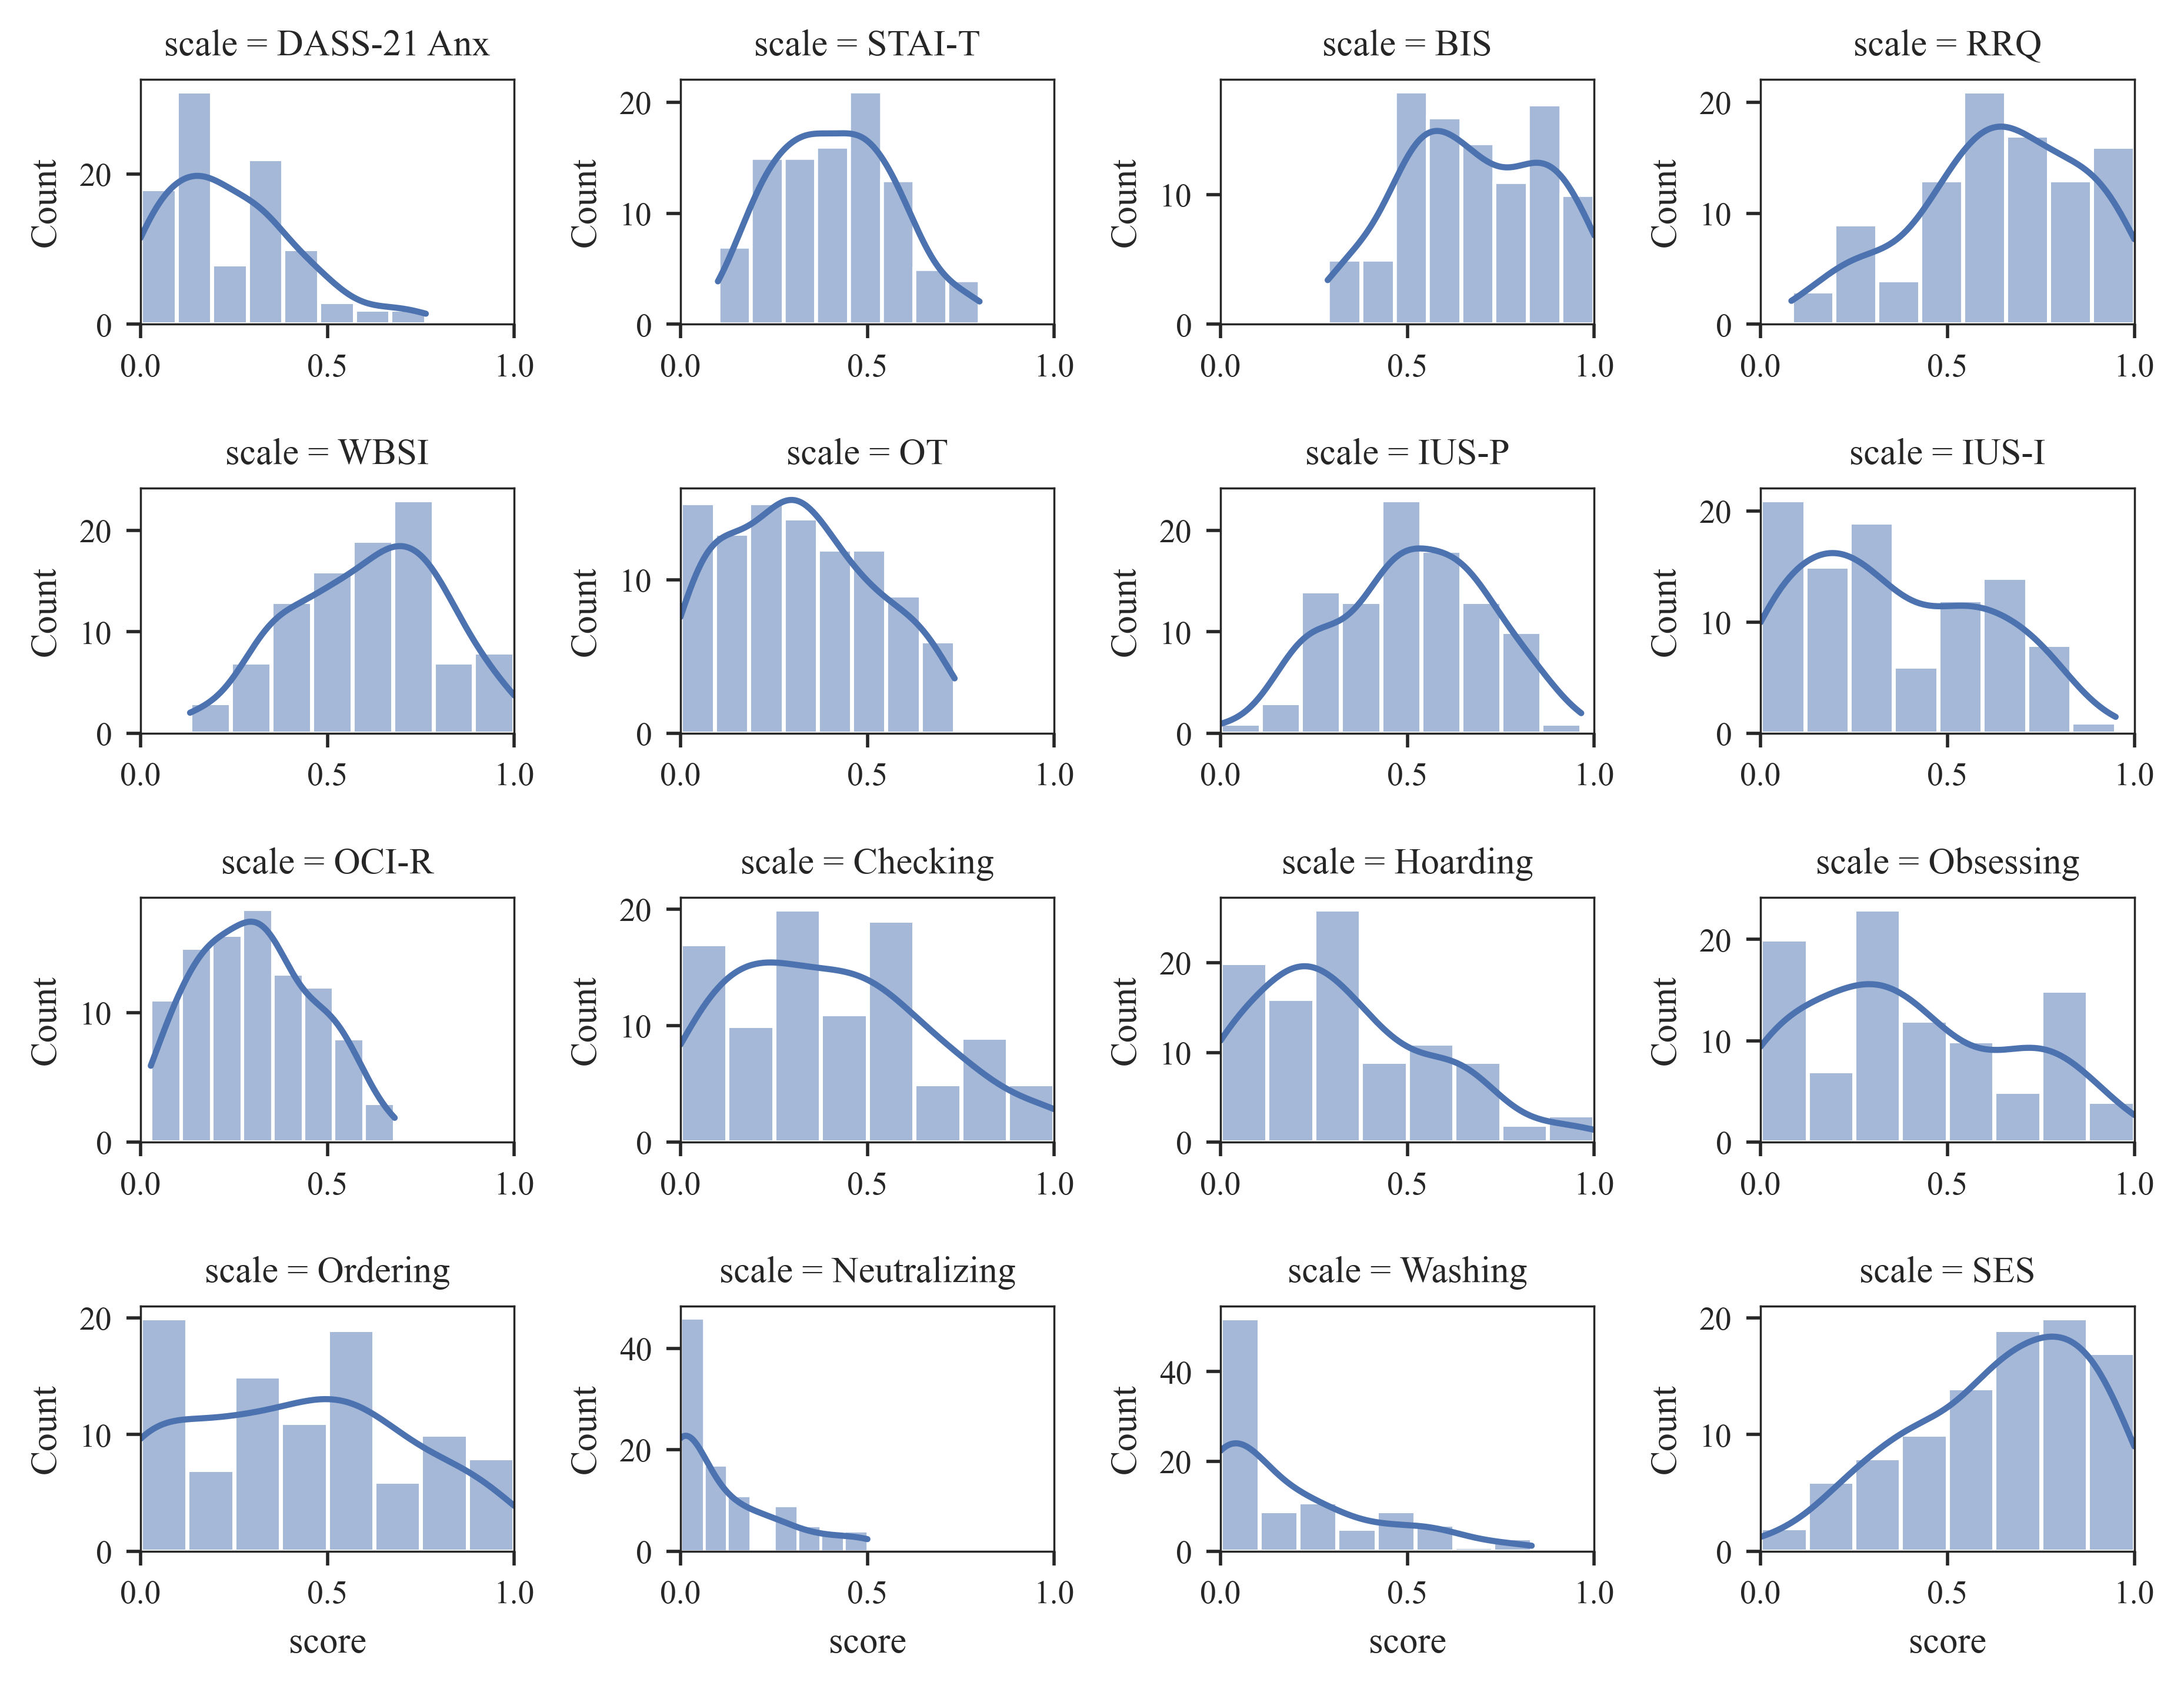

In [25]:
sns.set_style("white")
sns.set_style("ticks")

cm = 1/2.54
dpi = 500

plt.rcParams['figure.dpi'] = dpi
plt.rcParams['figure.dpi'] = dpi
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['axes.labelsize'] = 9
plt.rcParams["axes.edgecolor"] = ".15"
plt.rcParams["axes.linewidth"]  = 0.5
plt.rcParams["axes.linewidth"]  = 0.5

sns.set_palette('deep')

g = sns.FacetGrid(
    transformed_df, 
    col='scale', 
    col_wrap=4,
    sharex=False,
    sharey=False,
    despine=False,
    height=3.5*cm,
    aspect= 1.5,
    # xlim=(0,1),
    subplot_kws={"xlim":(0,1)}

)

g.map_dataframe(
    sns.histplot, 
    x="score",
    kde=True
)

fig = g.fig
fig.set_size_inches(19*cm, 15*cm)

plt.show()
# fig.savefig(f'../data/scales_density/train_scales_density', bbox_inches='tight', pad_inches=0.01)

- test

In [26]:
questionnaire_results_test.head()

,DASS-21 Anx,STAI-T,BIS,RRQ,WBSI,OT,IUS-P,IUS-I,OCI-R,Checking,Hoarding,Obsessing,Ordering,Neutralizing,Washing,SES
0,2.71,2.85,3.71,4.50,4.73,2.2,4.57,3.4,3.06,3.33,1.67,5.00,5.00,2.33,1.00,3.3
1,1.14,1.70,2.43,2.58,3.07,2.6,2.57,2.0,1.78,2.67,2.00,2.00,1.67,1.33,1.00,3.0
2,1.14,2.35,3.43,3.83,3.67,3.2,3.86,2.4,2.22,3.67,1.00,2.00,3.67,1.00,2.00,3.0
3,1.43,2.40,3.29,4.00,3.73,3.0,4.00,3.6,1.72,1.67,1.67,2.00,2.33,1.33,1.33,2.4
4,1.29,1.85,3.14,3.00,3.07,2.8,3.29,1.8,1.50,1.33,1.33,1.67,2.33,1.00,1.33,2.7


Normalize to get 0-1 scale range

In [27]:
df = questionnaire_results_test.copy()

df["DASS-21 Anx"] = (df["DASS-21 Anx"] - 1)/3
df["STAI-T"] = (df["STAI-T"] -1 ) /3
df["BIS"] = (df["BIS"]-1 ) /3
df["RRQ"] = (df["RRQ"]-1 ) /4
df["WBSI"] = (df["WBSI"]-1 ) /4
df["OT"] = (df["OT"] -1) /6
df["IUS-P"] = (df["IUS-P"]-1 ) /4
df["IUS-I"] = (df["IUS-I"]-1 ) /4
df["OCI-R"] = (df["OCI-R"]-1 ) /4
df["Checking"] = (df["Checking"]-1 ) /4
df["Hoarding"] = (df["Hoarding"]-1 ) /4
df["Obsessing"] = (df["Obsessing"]-1 ) /4
df["Ordering"] = (df["Ordering"]-1 ) /4
df["Neutralizing"] = (df["Neutralizing"]-1 ) /4
df["Washing"] = (df["Washing"]-1 ) /4
df["SES"] = (df["SES"]-1 ) /3

In [28]:
df.head()

,DASS-21 Anx,STAI-T,BIS,RRQ,WBSI,OT,IUS-P,IUS-I,OCI-R,Checking,Hoarding,Obsessing,Ordering,Neutralizing,Washing,SES
0,0.570000,0.616667,0.903333,0.8750,0.9325,0.200000,0.8925,0.60,0.515,0.5825,0.1675,1.0000,1.0000,0.3325,0.0000,0.766667
1,0.046667,0.233333,0.476667,0.3950,0.5175,0.266667,0.3925,0.25,0.195,0.4175,0.2500,0.2500,0.1675,0.0825,0.0000,0.666667
2,0.046667,0.450000,0.810000,0.7075,0.6675,0.366667,0.7150,0.35,0.305,0.6675,0.0000,0.2500,0.6675,0.0000,0.2500,0.666667
3,0.143333,0.466667,0.763333,0.7500,0.6825,0.333333,0.7500,0.65,0.180,0.1675,0.1675,0.2500,0.3325,0.0825,0.0825,0.466667
4,0.096667,0.283333,0.713333,0.5000,0.5175,0.300000,0.5725,0.20,0.125,0.0825,0.0825,0.1675,0.3325,0.0000,0.0825,0.566667


Transform df to hue-redeable form

In [29]:
# Create an empty list to store the transformed data
transformed_data = []

# Iterate through each row of the original DataFrame
for index, row in df.iterrows():
    # Iterate through each column (questionnaire scale)
    for scale_name, score in row.items():
        # Append a dictionary containing score and scale name to the transformed data list
        transformed_data.append({'score': score, 'scale': scale_name, 'dataset': 'test'})

# Create a new DataFrame from the transformed data list
transformed_df = pd.DataFrame(transformed_data)

In [30]:
transformed_test_df = transformed_df
transformed_test_df.head()

,score,scale,dataset
0,0.570000,DASS-21 Anx,test
1,0.616667,STAI-T,test
2,0.903333,BIS,test
3,0.875000,RRQ,test
4,0.932500,WBSI,test


Plot distributions of questionnaires scores

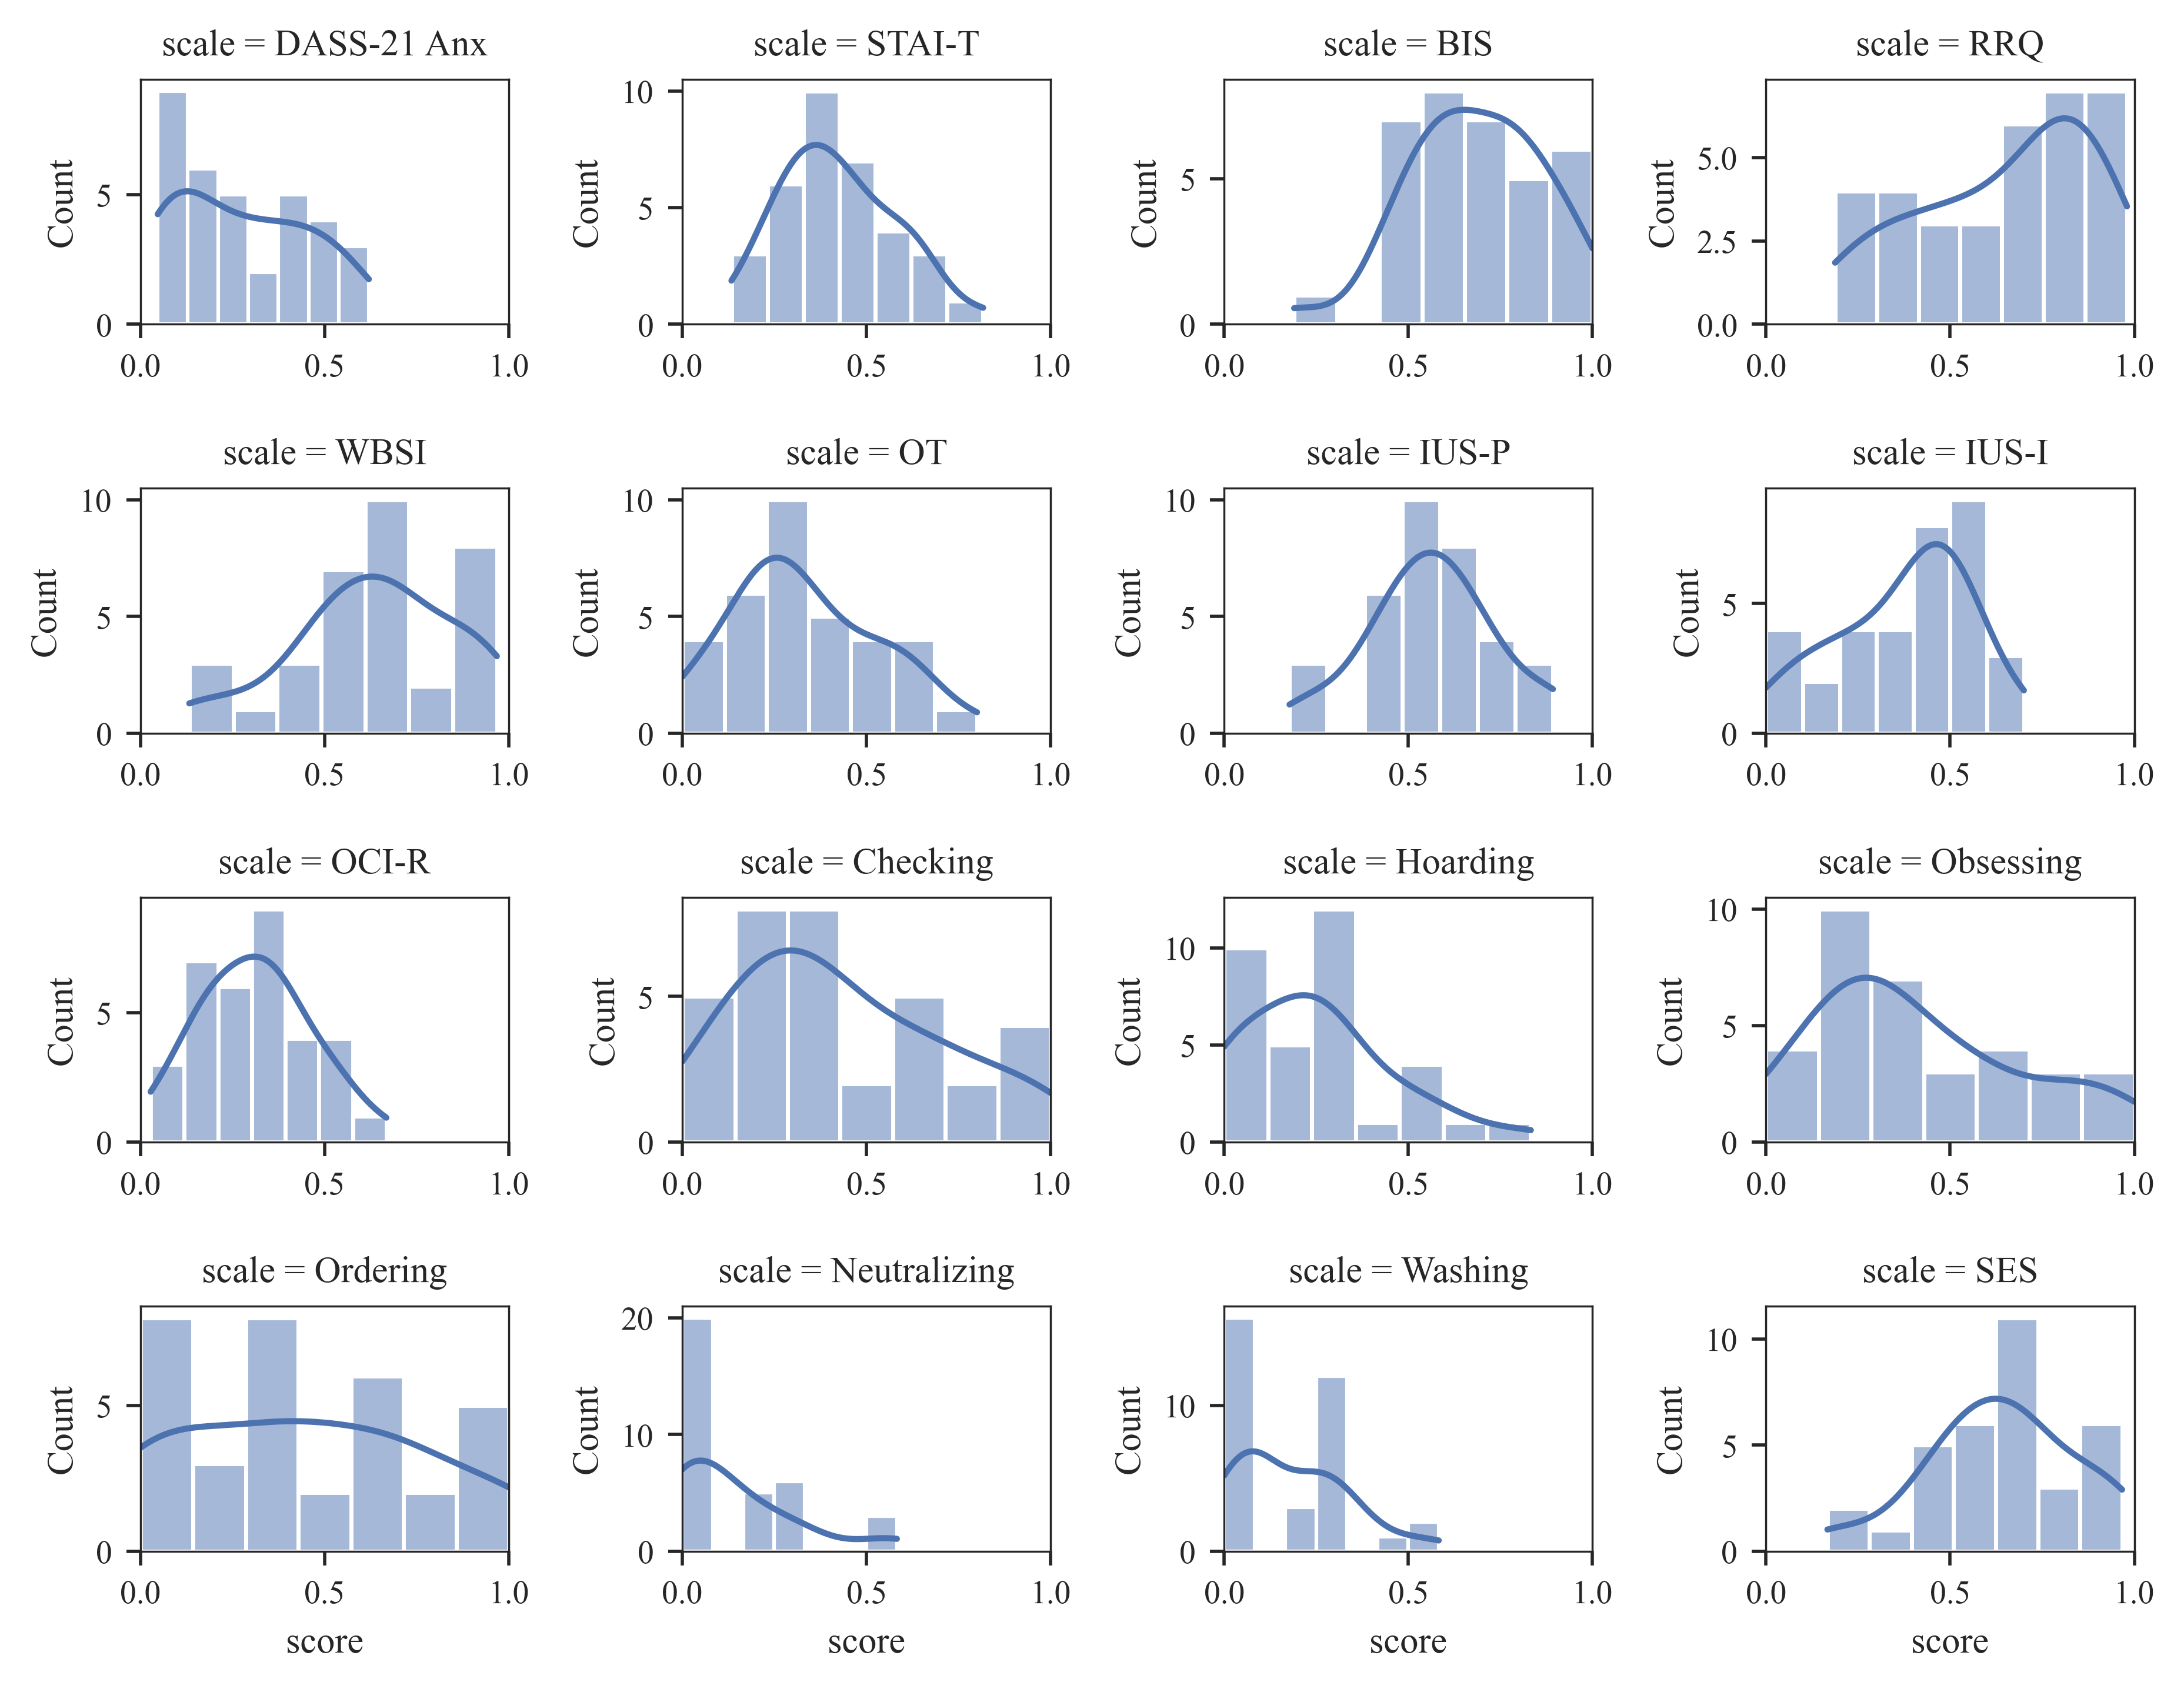

In [31]:
sns.set_style("white")
sns.set_style("ticks")

cm = 1/2.54
dpi = 500

plt.rcParams['figure.dpi'] = dpi
plt.rcParams['figure.dpi'] = dpi
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['axes.labelsize'] = 9
plt.rcParams["axes.edgecolor"] = ".15"
plt.rcParams["axes.linewidth"]  = 0.5
plt.rcParams["axes.linewidth"]  = 0.5

sns.set_palette('deep')

g = sns.FacetGrid(
    transformed_df, 
    col='scale', 
    col_wrap=4,
    sharex=False,
    sharey=False,
    despine=False,
    height=3.5*cm,
    aspect= 1.5,
    # xlim=(0,1),
    subplot_kws={"xlim":(0,1)}

)

g.map_dataframe(
    sns.histplot, 
    x="score",
    kde=True
)

fig = g.fig
fig.set_size_inches(19*cm, 15*cm)

plt.show()
# fig.savefig(f'../data/scales_density/test_scales_density', bbox_inches='tight', pad_inches=0.01)

- one plot

In [32]:
q_dataset_df = pd.concat([transformed_train_df, transformed_test_df], ignore_index=True)
q_dataset_df.head()

,score,scale,dataset
0,0.143333,DASS-21 Anx,train
1,0.183333,STAI-T,train
2,0.476667,BIS,train
3,0.292500,RRQ,train
4,0.600000,WBSI,train


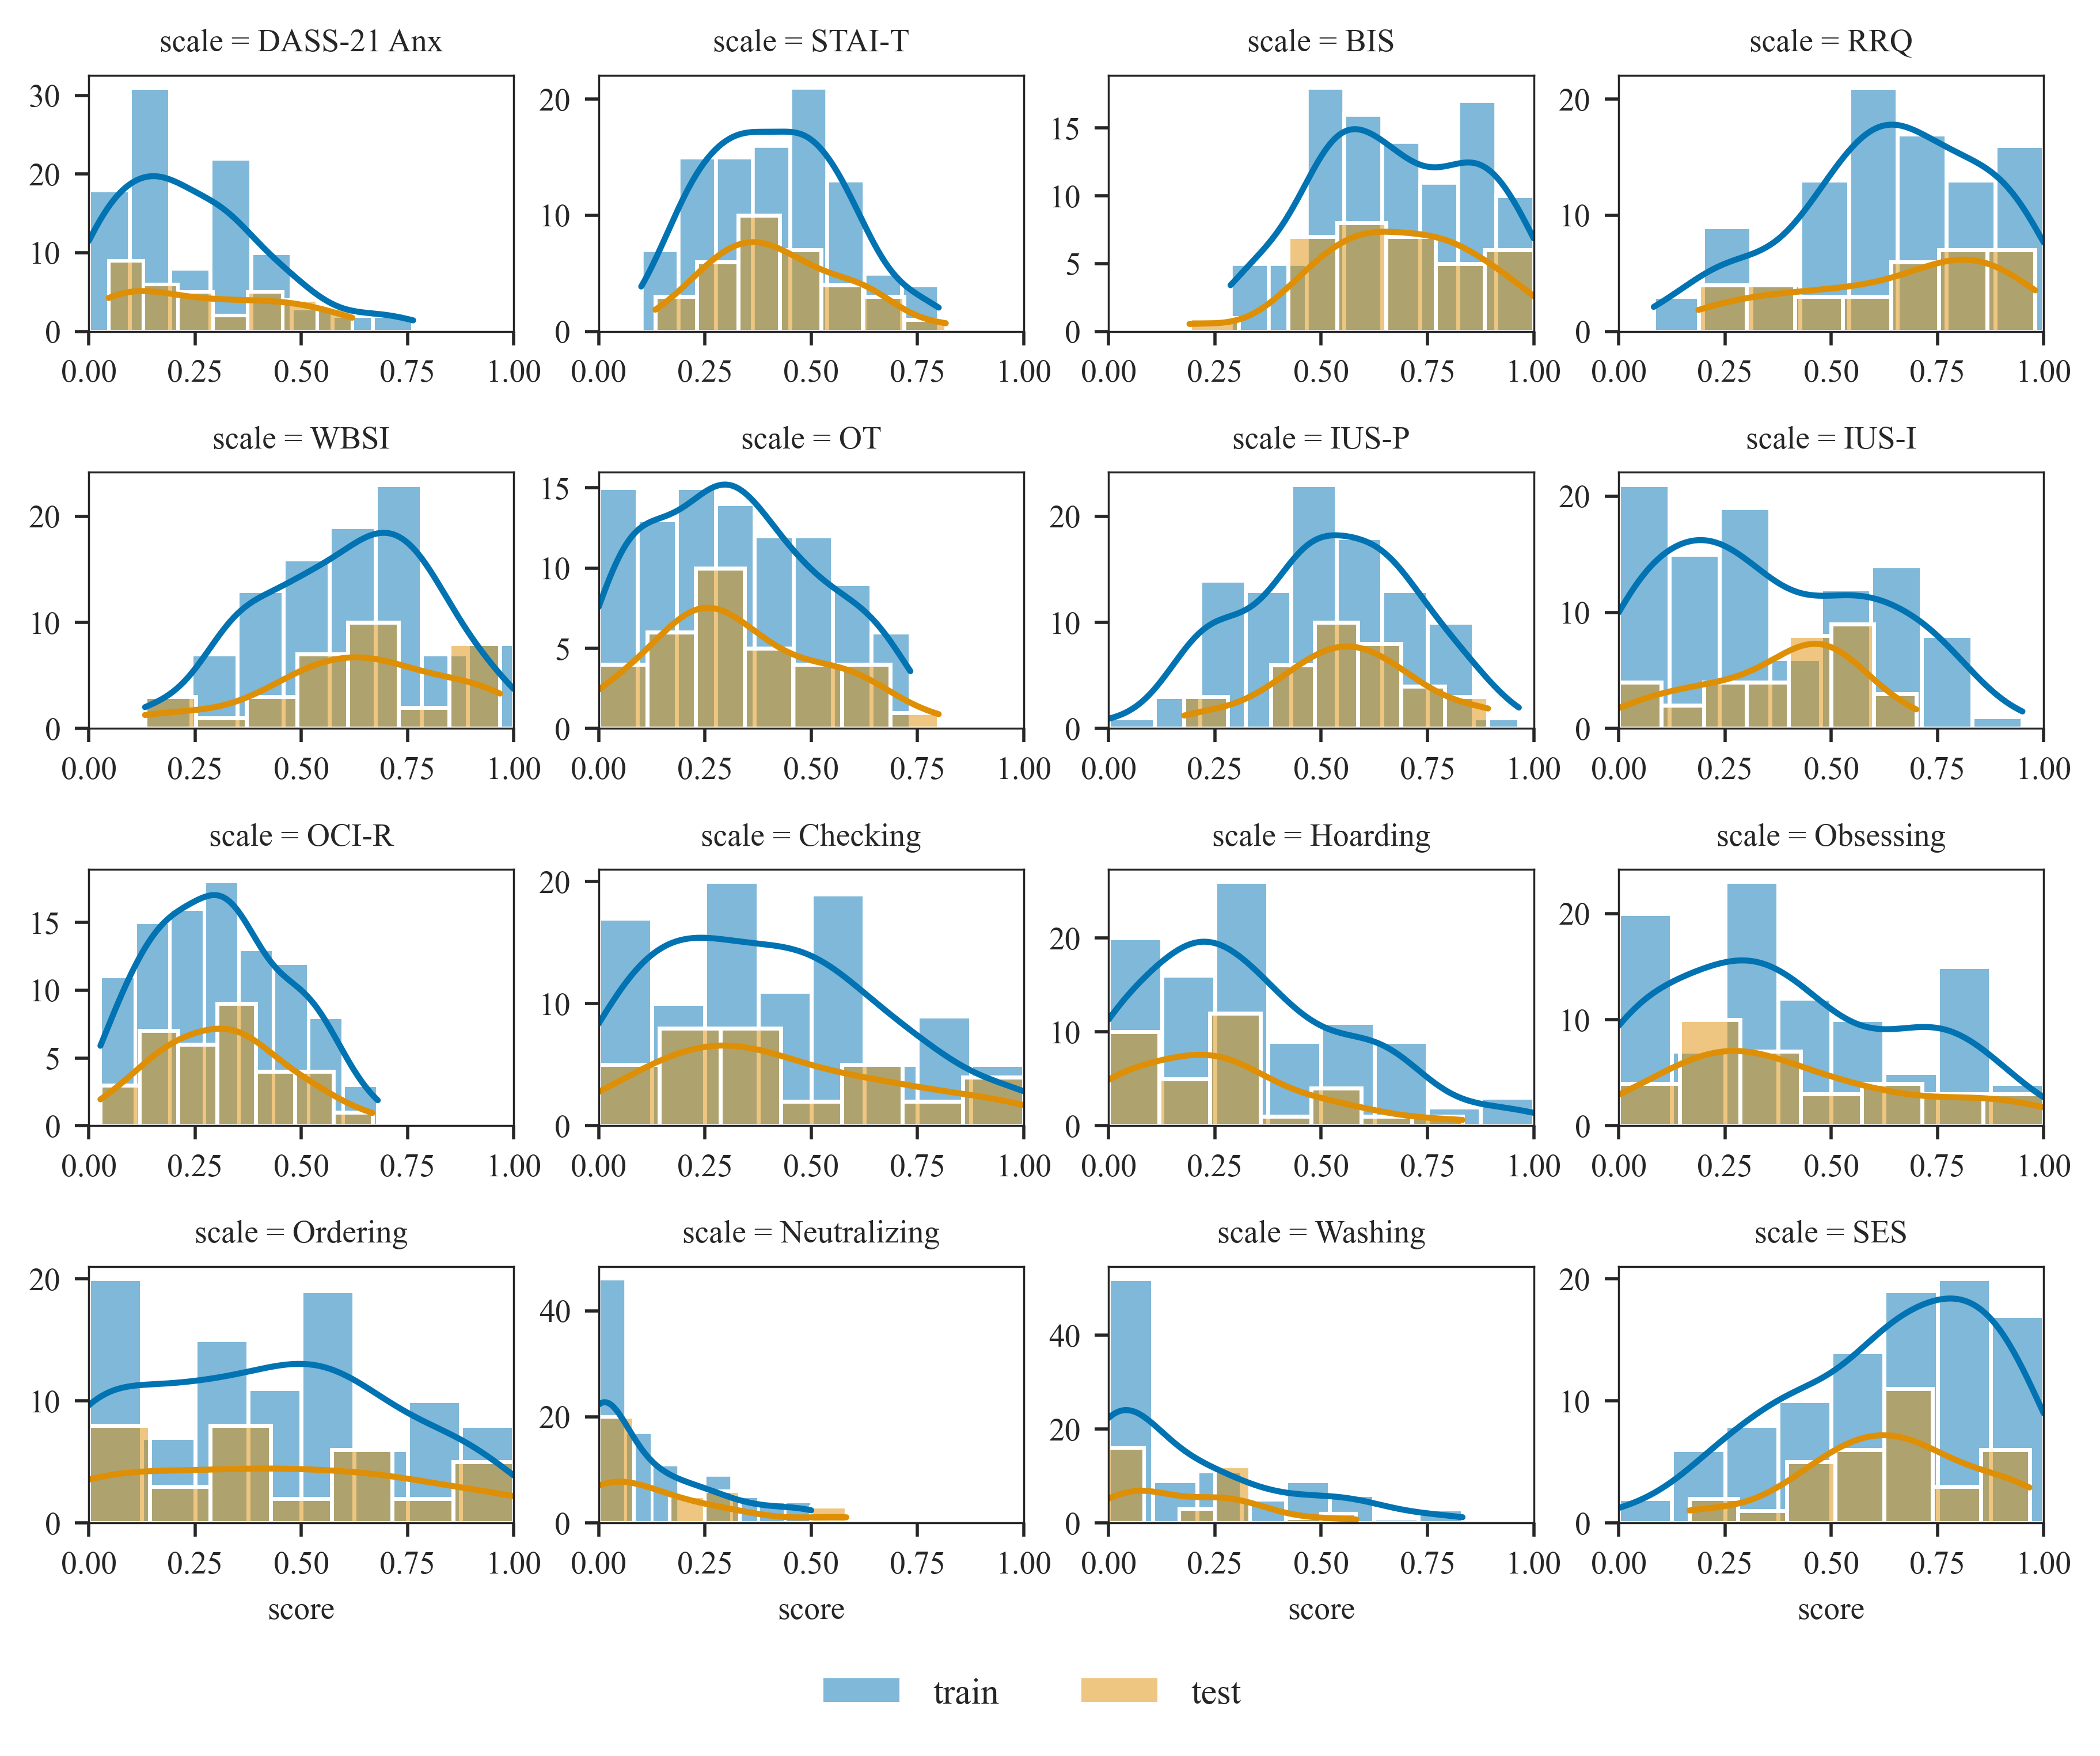

In [88]:
sns.set_style("ticks")

cm = 1/2.54
dpi = 500

plt.rcParams['figure.dpi'] = dpi
plt.rcParams['figure.dpi'] = dpi
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['axes.labelsize'] = 8
plt.rcParams["axes.edgecolor"] = ".15"
plt.rcParams["axes.linewidth"]  = 0.5
plt.rcParams["axes.linewidth"]  = 0.5

colors = [sns.color_palette("colorblind")[0], sns.color_palette("colorblind")[1], 'gray']
sns.set_palette(colors)

# custom_palette = ["#4dac26",  '#d01c8b']
# sns.set_palette(custom_palette)
# sns.set_palette('colorblind')



g = sns.FacetGrid(
    q_dataset_df, 
    col='scale', 
    col_wrap=4,
    sharex=False,
    sharey=False,
    despine=False,
    height=3.5*cm,
    aspect= 1.5,
    subplot_kws={"xlim":(0,1)},
    legend_out=False,
    hue='dataset',


)

g.map_dataframe(
    sns.histplot, 
    x="score",
    kde=True,
    cbar_kws={'saturation':0.9}
)

g.add_legend()

fig = g.fig
fig.set_size_inches(19*cm, 15*cm)

g.fig.subplots_adjust(wspace=.2, hspace=.55)
g.set_ylabels(label=None, clear_inner=True)

sns.move_legend(
    g, "lower center",
    bbox_to_anchor=(.5, -0.04), ncol=2, title=None, frameon=False,
)
plt.setp(g._legend.get_texts(), fontsize=9)

plt.show()
fig.savefig(f'../data/scales_density/train_test_scales_density', bbox_inches='tight', pad_inches=0.01)

### Comparison of train and test questionnaires scores

In [41]:
columns = questionnaire_results_train.columns.to_list()
scales_differences_results = []

for scale in columns:
    print(f"Scale: {scale}")
    X_train = questionnaire_results_train[scale].to_numpy().flatten()
    X_test = questionnaire_results_test[scale].to_numpy().flatten()
    
    t_stat, p_val = scipy.stats.ttest_ind(X_train, X_test, permutations=1000)
    print(f"t-stat: {t_stat}, p-value: {p_val}\n")
    
    scales_differences_results.append((t_stat, p_val))

Scale: DASS-21 Anx
t-stat: -0.9689991746957731, p-value: 0.364

Scale: STAI-T
t-stat: -0.3403884309774058, p-value: 0.723

Scale: BIS
t-stat: -0.15088132121488396, p-value: 0.874

Scale: RRQ
t-stat: -0.26907934844451575, p-value: 0.791

Scale: WBSI
t-stat: -0.593801129534715, p-value: 0.552

Scale: OT
t-stat: -0.35878831461926924, p-value: 0.72

Scale: IUS-P
t-stat: -1.1996762704676236, p-value: 0.22

Scale: IUS-I
t-stat: -0.34650231167562323, p-value: 0.709

Scale: OCI-R
t-stat: -0.16233813457101817, p-value: 0.877

Scale: Checking
t-stat: -0.5590666026972716, p-value: 0.578

Scale: Hoarding
t-stat: 1.499900578549815, p-value: 0.13

Scale: Obsessing
t-stat: -0.3217027088327311, p-value: 0.758

Scale: Ordering
t-stat: -0.4150432300873317, p-value: 0.667

Scale: Neutralizing
t-stat: -1.0336355102067416, p-value: 0.291

Scale: Washing
t-stat: 0.12282717416717885, p-value: 0.903

Scale: SES
t-stat: 0.05969361271122827, p-value: 0.96



In [48]:
scales_differences_results_df = pd.DataFrame([np.array(scales_differences_results)[:,1]], columns=columns, index=pd.Index(['p-value']))
scales_differences_results_df = scales_differences_results_df.round(3)
scales_differences_results_df

,DASS-21 Anx,STAI-T,BIS,RRQ,WBSI,OT,IUS-P,IUS-I,OCI-R,Checking,Hoarding,Obsessing,Ordering,Neutralizing,Washing,SES
p-value,0.364,0.723,0.874,0.791,0.552,0.72,0.22,0.709,0.877,0.578,0.13,0.758,0.667,0.291,0.903,0.96


In [49]:
scales_differences_results_df.to_csv('../public_data/results/questionnaires/train_test_staistical_tests_results.csv')